# Data Loading and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dython import nominal
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import pickle

In [2]:
data_dir = './data/'

In [3]:
results_dir = './data/results/'

In [4]:
models_dir = './models/'

In [5]:
model_name = 'decision_tree_classification'

In [6]:
classification_data = pd.read_csv(data_dir+'classification_data.csv', index_col=[0])

# Decision Tree (Classification)

In [7]:
classification_data

,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,yes,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,1,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,yes,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,1,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,yes,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,1,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,yes,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,1,pendant,black,scattered,urban
4,edible,convex,smooth,gray,no,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,1,evanescent,brown,abundant,grasses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,edible,knobbed,smooth,brown,no,none,attached,close,broad,yellow,enlarging,unknown,smooth,smooth,orange,1,pendant,buff,clustered,leaves
8120,edible,convex,smooth,brown,no,none,attached,close,broad,yellow,enlarging,unknown,smooth,smooth,brown,1,pendant,buff,several,leaves
8121,edible,flat,smooth,brown,no,none,attached,close,broad,brown,enlarging,unknown,smooth,smooth,orange,1,pendant,buff,clustered,leaves
8122,poisonous,knobbed,scaly,brown,no,fishy,free,close,narrow,buff,tapering,unknown,smooth,silky,white,1,evanescent,white,several,leaves


In [8]:
classification_data.shape

(8124, 20)

In [9]:
dep_var = 'edible'

In [10]:
X = classification_data.iloc[:,classification_data.columns != dep_var]

In [11]:
y = classification_data[dep_var]

In [12]:
y

0       poisonous
1          edible
2          edible
3       poisonous
4          edible
          ...    
8119       edible
8120       edible
8121       edible
8122    poisonous
8123       edible
Name: edible, Length: 8124, dtype: object

In [13]:
# Random 6-digit seed
test_seed = 513370

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=test_seed, stratify=y)

Initialise the dataframe that holds the results of the datasets

In [15]:
columns = ['task', 'model', 'seed', 'split', 'criterions', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'train_accuracy', 'valid_accuracy', 'valid_precision', 'valid_recall', 'valid_f1_score', 'valid_auroc']
decision_tree_classification_results_df = pd.DataFrame(columns=columns)
df_rows = 0

In [16]:
# 5 random 6 digit numbers
seeds = [660108, 720389, 193768, 586930, 327407]

Now we need to prepare our data and the cross-validation process so that we can start training.

In [17]:
pd.options.mode.chained_assignment = None  # default='warn'
# Cross-Validation Pipeline
for seed in seeds:
    print(f'Starting training for seed {seed}')
    # assign the tuned parameters
    split = 0
    criterions = ['gini', 'entropy']
    max_depths = [depth for depth in range(5, 65, 5)]
    min_samples_splits = [2, 3, 4]
    min_samples_leaves = [8, 10, 12]
    max_features_n = ['auto', 'sqrt', 'log2']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)
    for train_index, valid_index in KFold(n_splits=5, shuffle=False).split(X_train):
        # Data Split
        split += 1
        X_train_curr_split = X_train.iloc[train_index]
        X_valid_curr_split = X_train.iloc[valid_index]
        y_train_curr_split = y_train.iloc[train_index]
        y_valid_curr_split = y_train.iloc[valid_index]
       
        # Avoiding data leakage for input values
        enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
        X_train_curr_split = enc.fit_transform(X_train_curr_split)
        X_valid_curr_split = enc.transform(X_valid_curr_split)
        
        # as output varaibles are stratified on, there is not any unknowon variable, therefore no possibility of data leakage
        encoder_dict = {'edible': 1,
                        'poisonous': 0}
        # transform the output into the right format
        y_train_curr_split = y_train_curr_split.replace(encoder_dict).values.flatten()
        y_valid_curr_split = y_valid_curr_split.replace(encoder_dict).values.flatten()
        for criterion in criterions:
            for max_depth in max_depths:
                for min_samples_split in min_samples_splits:
                    for min_samples_leaf in min_samples_leaves:
                        for max_features in max_features_n:
                            pipe = make_pipeline(preprocessing.StandardScaler(), 
                                                 DecisionTreeClassifier(criterion=criterion,
                                                                        max_depth=max_depth,
                                                                        min_samples_split=min_samples_split,
                                                                        min_samples_leaf=min_samples_leaf,
                                                                        max_features=max_features,
                                                                        random_state=seed
                                                                       )
                                                )
                            # train the model
                            pipe.fit(X_train_curr_split, y_train_curr_split) 
                            # Obtain metric scores
                            valid_predictions = pipe.predict(X_valid_curr_split)
                            valid_prec_score = precision_score(y_valid_curr_split, valid_predictions)
                            valid_rec_score = recall_score(y_valid_curr_split, valid_predictions)
                            valid_f1_score = f1_score(y_valid_curr_split, valid_predictions)
                            fpr, tpr, threshold = roc_curve(y_valid_curr_split, valid_predictions)
                            valid_auroc = auc(fpr, tpr)
                            valid_accuracy = pipe.score(X_valid_curr_split, y_valid_curr_split)
                            train_accuracy = pipe.score(X_train_curr_split, y_train_curr_split)
                            decision_tree_classification_results_df.loc[df_rows] = ['classification', 
                                                                                    'decision tree', 
                                                                                    seed,
                                                                                    split,
                                                                                    criterion,
                                                                                    max_depth,
                                                                                    min_samples_split,
                                                                                    min_samples_leaf,
                                                                                    max_features,
                                                                                    train_accuracy,
                                                                                    valid_accuracy,
                                                                                    valid_prec_score,
                                                                                    valid_rec_score,
                                                                                    valid_f1_score,
                                                                                    valid_auroc]
                            # increment the rows variable
                            df_rows +=1
    print(f'Done training for seed {seed}')     

Starting training for seed 660108
Done training for seed 660108
Starting training for seed 720389
Done training for seed 720389
Starting training for seed 193768
Done training for seed 193768
Starting training for seed 586930
Done training for seed 586930
Starting training for seed 327407
Done training for seed 327407


In [17]:
def group_seeded_data(data, groupby_columns, droped_cols=['seed', 'split']):
    grouped_data = data.groupby(groupby_columns).agg('mean').reset_index().drop(droped_cols, axis=1)
    return grouped_data

In [16]:
decision_tree_classification_results_df

,task,model,seed,split,criterions,max_depth,min_samples_split,min_samples_leaf,max_features,train_accuracy,valid_accuracy,valid_precision,valid_recall,valid_f1_score,valid_auroc
0,classification,decision tree,660108,1,gini,5,2,8,auto,0.982497,0.976923,0.98538,0.971182,0.978229,0.977340
1,classification,decision tree,660108,1,gini,5,2,8,sqrt,0.982497,0.976923,0.98538,0.971182,0.978229,0.977340
2,classification,decision tree,660108,1,gini,5,2,8,log2,0.982497,0.976923,0.98538,0.971182,0.978229,0.977340
3,classification,decision tree,660108,1,gini,5,2,10,auto,0.982497,0.976923,0.98538,0.971182,0.978229,0.977340
4,classification,decision tree,660108,1,gini,5,2,10,sqrt,0.982497,0.976923,0.98538,0.971182,0.978229,0.977340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16195,classification,decision tree,327407,5,entropy,60,4,10,sqrt,0.996154,0.998460,0.99701,1.000000,0.998503,0.998418
16196,classification,decision tree,327407,5,entropy,60,4,10,log2,0.996154,0.998460,0.99701,1.000000,0.998503,0.998418
16197,classification,decision tree,327407,5,entropy,60,4,12,auto,0.996154,0.998460,0.99701,1.000000,0.998503,0.998418
16198,classification,decision tree,327407,5,entropy,60,4,12,sqrt,0.996154,0.998460,0.99701,1.000000,0.998503,0.998418


In [20]:
pd.options.mode.chained_assignment = 'warn'

In [21]:
decision_tree_classification_results_df.to_csv(results_dir + 'decision_tree_classification_results_df.csv')

Aggregate the values so that we average the results for each random seed

In [18]:
grouped_decision_tree_classification_results_df = group_seeded_data(decision_tree_classification_results_df, 
                                                                    ['criterions', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features'],
                                                                   )

In [19]:
grouped_decision_tree_classification_results_df

,criterions,max_depth,min_samples_split,min_samples_leaf,max_features,train_accuracy,valid_accuracy,valid_precision,valid_recall,valid_f1_score,valid_auroc
0,entropy,5,2,8,auto,0.988698,0.988306,0.993217,0.984228,0.988648,0.988478
1,entropy,5,2,8,log2,0.988698,0.988306,0.993217,0.984228,0.988648,0.988478
2,entropy,5,2,8,sqrt,0.988698,0.988306,0.993217,0.984228,0.988648,0.988478
3,entropy,5,2,10,auto,0.986221,0.985906,0.991051,0.981746,0.986321,0.986079
4,entropy,5,2,10,log2,0.986221,0.985906,0.991051,0.981746,0.986321,0.986079
...,...,...,...,...,...,...,...,...,...,...,...
643,gini,60,4,10,log2,0.996684,0.995907,0.995836,0.996234,0.996027,0.995897
644,gini,60,4,10,sqrt,0.996684,0.995907,0.995836,0.996234,0.996027,0.995897
645,gini,60,4,12,auto,0.996276,0.995291,0.995859,0.995037,0.995437,0.995278
646,gini,60,4,12,log2,0.996276,0.995291,0.995859,0.995037,0.995437,0.995278


In [23]:
grouped_decision_tree_classification_results_df.to_csv(results_dir + 'grouped_decision_tree_classification_results_df.csv')

## Functions

In [20]:
def plot_train_test_accuracy(data, by_column='max_depth', title='Line Graph', title_size=25, axes_size=15, tick_size=12, acc = 'valid_accuracy'):
    grouped_data = data.groupby([by_column]).agg(train_accuracy=('train_accuracy', 'mean'),
                                                 valid_accuracy=('valid_accuracy', 'mean')).reset_index()

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(grouped_data[by_column],
             grouped_data['train_accuracy'], 
             label = 'train_accuracy')
    plt.plot(grouped_data[by_column],
             grouped_data['valid_accuracy'], 
             label = 'valid_accuracy')
    plt.legend()
    acc_label = acc.split('_')[0]
    fig.suptitle(title + f' for valid and train accuracies', fontsize=title_size,  y=1.02)
    ax.set_xlabel('Max depth', fontsize=axes_size)
    ax.set_ylabel('Accuracy'.capitalize(), fontsize=axes_size)
    ax.tick_params(axis='x', which='major', labelsize=tick_size, labelrotation=90)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

In [21]:
def plot_bar_for_criterion(data, criterion_type, title='Bar Graph', title_size=25, axes_size=15, tick_size=12, acc = 'valid_accuracy'):
    data_criterion = data[data['criterions'] == criterion_type].copy()
    grouped_data = data_criterion.groupby(['min_samples_split', 'min_samples_leaf', 'max_features']).agg(train_accuracy=('train_accuracy', 'mean'),
                                                                                                         valid_accuracy=('valid_accuracy', 'mean'),
                                                                                                         valid_precision=('valid_precision', 'mean'),
                                                                                                         valid_recall=('valid_recall', 'mean'),
                                                                                                         valid_f1_score=('valid_f1_score', 'mean'),
                                                                                                         valid_auroc=('valid_auroc', 'mean')).reset_index()
    fig, ax = plt.subplots(figsize=(10, 5))
    labels = []
    for row in grouped_data.index:
        label = str(grouped_data.loc[row, 'min_samples_split']) + '_' + str(grouped_data.loc[row, 'min_samples_leaf']) + '_' + str(grouped_data.loc[row, 'max_features'])
        labels.append(label)
    plt.bar([row for row in grouped_data.index],
            grouped_data.loc[:, acc], 
            tick_label = labels)
    acc_label = acc.split('_')[0]
    fig.suptitle(title + f' for {criterion_type} criterion with {acc} as values', fontsize=title_size,  y=1.02)
    ax.set_xlabel('min_samples_split, min_samples_leaf, max_features', fontsize=axes_size)
    ax.set_ylabel(f'{acc_label} accuracy'.capitalize(), fontsize=axes_size)
    ax.tick_params(axis='x', which='major', labelsize=tick_size, labelrotation=90)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

In [23]:
def plot_line(data, x_column='C', groupby_column = 'penalty', title='Line graph', title_size=25, axes_size=15, tick_size=12, acc = 'valid_accuracy'):
    grouped_data = data.groupby([x_column, groupby_column]).agg(acc=(acc, 'mean')).reset_index()

    fig, ax = plt.subplots(figsize=(10, 5))
    for feat in grouped_data[groupby_column].unique():
        feat_data = grouped_data[grouped_data[groupby_column]==feat].copy()
        X = feat_data[x_column]
        y = feat_data['acc'].copy()
        plt.plot(X, y, label=f'{groupby_column}_{feat}')
    
    acc_label = acc
    fig.legend(bbox_to_anchor=(0.9, 0.9))
    fig.suptitle(title + f' for {acc} change in regards to {x_column} for each value of {groupby_column}', fontsize=title_size,  y=1.02)
    ax.set_xlabel(f'{x_column}', fontsize=axes_size)
    ax.set_ylabel(f'{acc_label}'.capitalize(), fontsize=axes_size)
    ax.set_xticks(grouped_data[x_column].unique())  # Set label locations.
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

In [58]:
def plot_conf_matrix(y_test, test_predictions, tick_size=12):
    conf_matrix = confusion_matrix(y_test, test_predictions)
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(conf_matrix, annot=True,linewidths=0.5,linecolor="red", fmt=".0f")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size, labelrotation=90)
    plt.show()

## Overal results demonstration

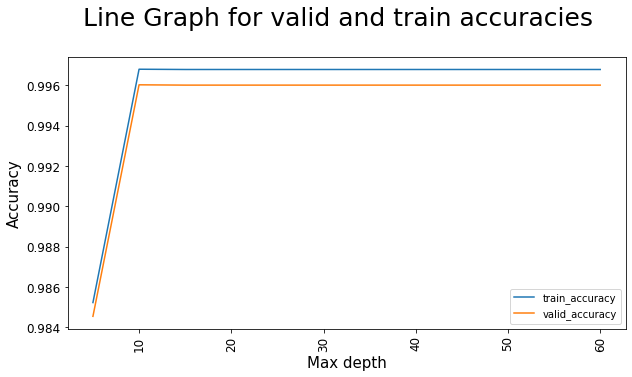

In [28]:
plot_train_test_accuracy(grouped_decision_tree_classification_results_df)

There is a high risk of overfitting when an arbitrarily big number for max_depth is chosen. Although, there seems to be no need to use a tree which is deeper than 10 nodes, it does not seem to overfitt the training data.

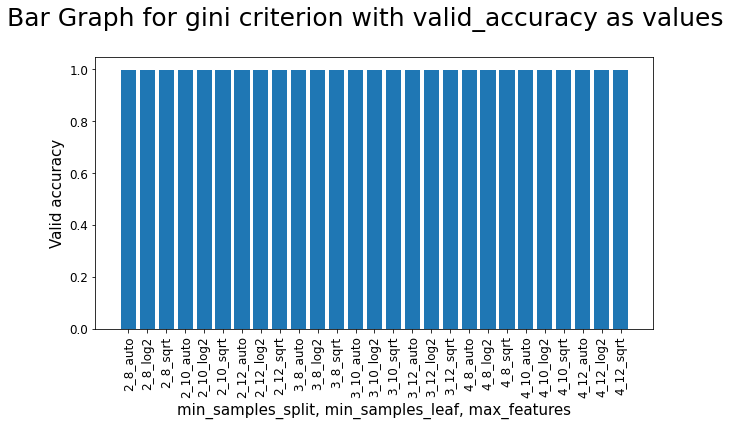

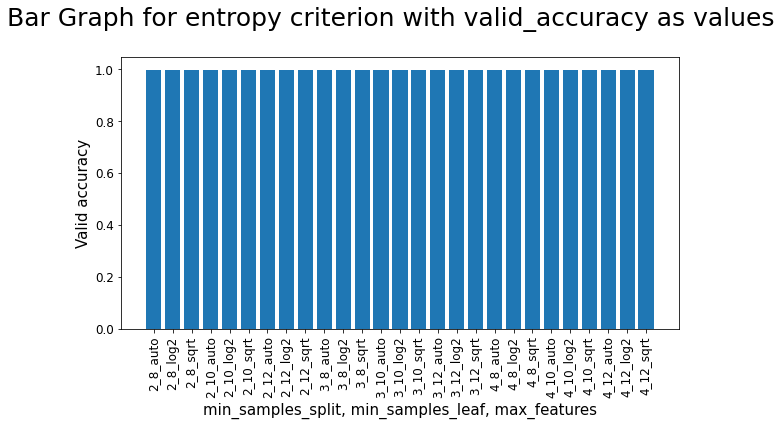

In [29]:
for criterion in decision_tree_classification_results_df.criterions.unique():
    plot_bar_for_criterion(grouped_decision_tree_classification_results_df, criterion)

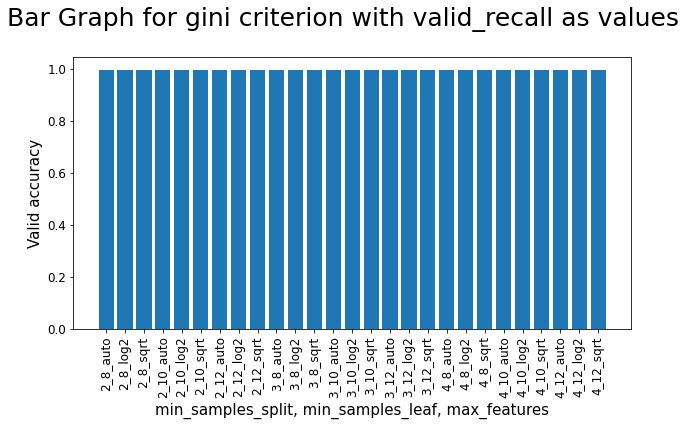

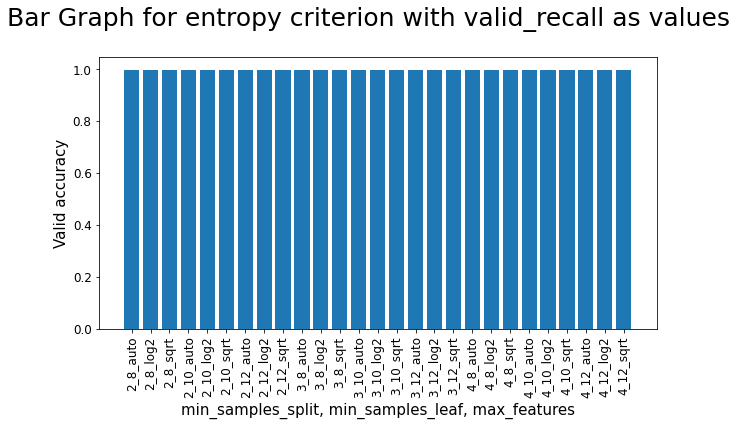

In [30]:
for criterion in decision_tree_classification_results_df.criterions.unique():
    plot_bar_for_criterion(grouped_decision_tree_classification_results_df, criterion, acc='valid_recall')

It can be seen that simillarly to max_depth, the other hyperparameters have very little impact on the metrics measured on the validation set.

------------

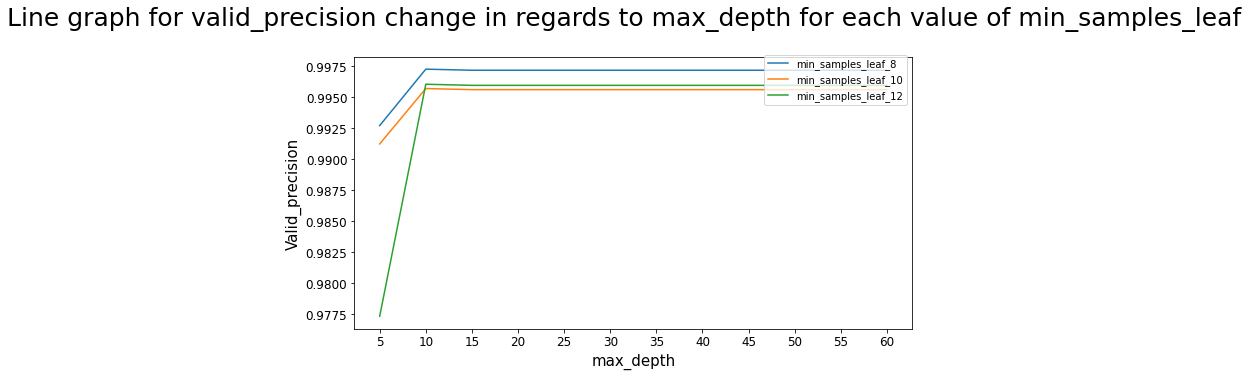

In [33]:
plot_line(grouped_decision_tree_classification_results_df, x_column='max_depth', groupby_column='min_samples_leaf', acc='valid_precision')

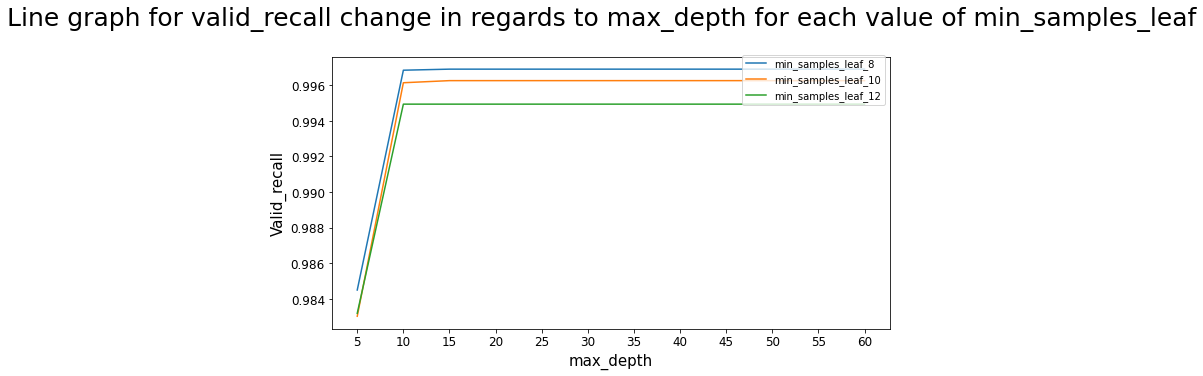

In [34]:
plot_line(grouped_decision_tree_classification_results_df, x_column='max_depth', groupby_column='min_samples_leaf', acc='valid_recall')

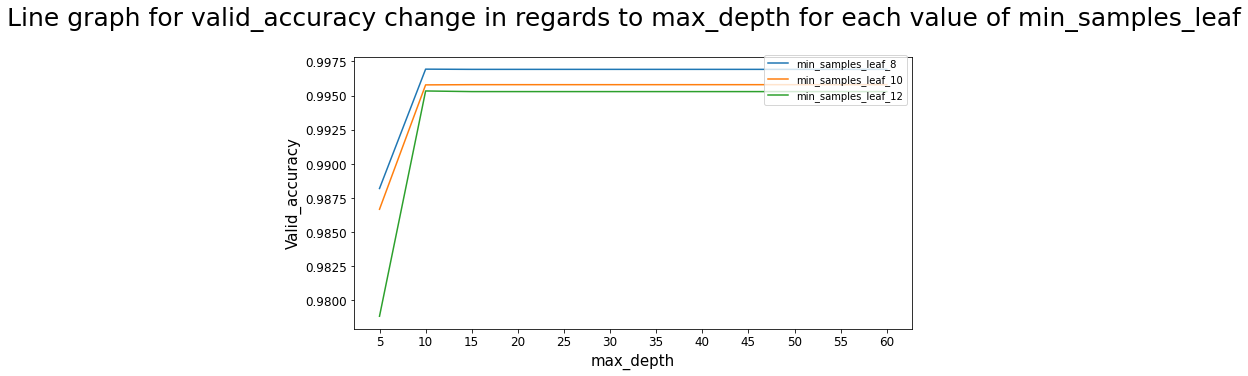

In [35]:
plot_line(grouped_decision_tree_classification_results_df, x_column='max_depth', groupby_column='min_samples_leaf', acc='valid_accuracy')

-----------------

As it was made clear in the EDA in the other notebook, data is distributed equally, therefore all of the above metrics are good model evaluators. However, when we are dealing with edible and poisonous mushrooms it is important to not mistake a poisonous for an edible mushroom (the opposite is not that important), therefore precision is the most important metric.

In [44]:
grouped_decision_tree_classification_results_df[grouped_decision_tree_classification_results_df['valid_precision'] == grouped_decision_tree_classification_results_df['valid_precision'].max()]

,criterions,max_depth,min_samples_split,min_samples_leaf,max_features,train_accuracy,valid_accuracy,valid_precision,valid_recall,valid_f1_score,valid_auroc
351,gini,10,2,8,auto,0.997707,0.997015,0.997514,0.996727,0.997112,0.997024
352,gini,10,2,8,log2,0.997707,0.997015,0.997514,0.996727,0.997112,0.997024
353,gini,10,2,8,sqrt,0.997707,0.997015,0.997514,0.996727,0.997112,0.997024
360,gini,10,3,8,auto,0.997707,0.997015,0.997514,0.996727,0.997112,0.997024
361,gini,10,3,8,log2,0.997707,0.997015,0.997514,0.996727,0.997112,0.997024
...,...,...,...,...,...,...,...,...,...,...,...
631,gini,60,3,8,log2,0.997707,0.997015,0.997514,0.996727,0.997112,0.997024
632,gini,60,3,8,sqrt,0.997707,0.997015,0.997514,0.996727,0.997112,0.997024
639,gini,60,4,8,auto,0.997707,0.997015,0.997514,0.996727,0.997112,0.997024
640,gini,60,4,8,log2,0.997707,0.997015,0.997514,0.996727,0.997112,0.997024


Now we need to save the best model and test it on the test data.

In [47]:
best_model = DecisionTreeClassifier(max_depth=10,
                                    criterion = 'gini',
                                    min_samples_split=2,
                                    min_samples_leaf=8,
                                    max_features='log2')

In [48]:
# Avoiding data leakage for input values
enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
X_train_enc = enc.fit_transform(X_train)
X_test_enc = enc.transform(X_test)

# as output varaibles are stratified on, there is not any unknowon variable, therefore no possibility of data leakage
encoder_dict = {'edible': 1,
                'poisonous': 0}
# transform the output into the right format
y_train_enc = y_train.replace(encoder_dict).values.flatten()
y_test_enc = y_test.replace(encoder_dict).values.flatten()

In [49]:
best_pipe = make_pipeline(preprocessing.StandardScaler(), 
                          best_model)

Train the model

In [50]:
best_pipe = best_pipe.fit(X_train_enc, y_train_enc) 

# Obtain metric scores

In [51]:
test_predictions = best_pipe.predict(X_test_enc)
test_prec_score = precision_score(y_test_enc, test_predictions)
test_rec_score = recall_score(y_test_enc, test_predictions)
test_f1_score = f1_score(y_test_enc, test_predictions)
fpr, tpr, threshold = roc_curve(y_test_enc, test_predictions)
test_auroc = auc(fpr, tpr)
test_accuracy = best_pipe.score(X_test_enc, y_test_enc)
train_accuracy = best_pipe.score(X_train_enc, y_train_enc)

### Results on test set

In [52]:
print(f"The predicion score on the test set for the best model is {test_prec_score.round(3)} \n")

The predicion score on the test set for the best model is 1.0 



In [53]:
print(f"The recall score on the test set for the best model is {test_rec_score.round(3)} \n")

The recall score on the test set for the best model is 1.0 



In [54]:
print(f"The f1-score on the test set for the best model is {test_f1_score.round(3)} \n")

The f1-score on the test set for the best model is 1.0 



In [55]:
print(f"The auroc score on the test set for the best model is {test_auroc.round(3)} \n")

The auroc score on the test set for the best model is 1.0 



In [56]:
print(f"The accuracy on the test set for the best model is {test_accuracy.round(3)} \n")

The accuracy on the test set for the best model is 1.0 



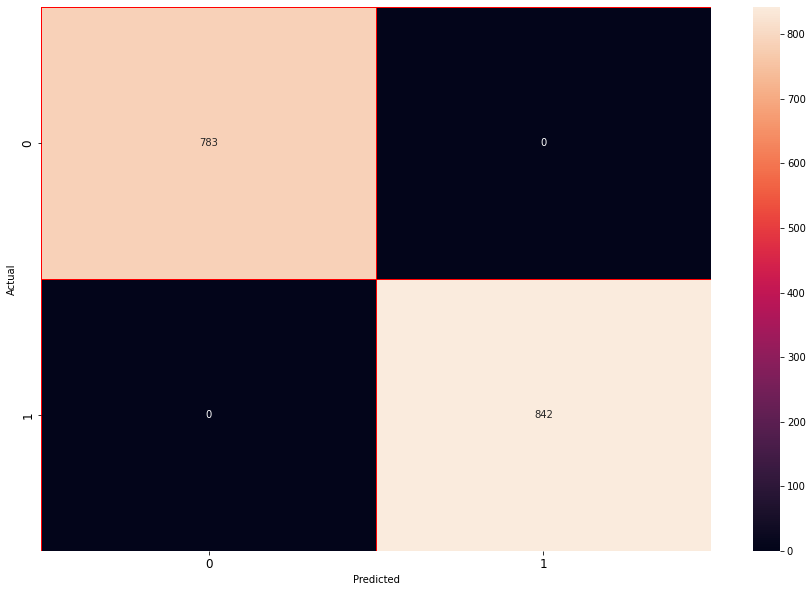

In [59]:
plot_conf_matrix(y_test_enc, test_predictions)

Save the model on disc

In [60]:
pickle.dump(best_pipe, open(models_dir+model_name, 'wb'))

Load the model from disk

In [61]:
loaded_best_pipe = pickle.load(open(models_dir+model_name, 'rb'))